# PennyLane Tests
*TS utilities in* ***PennyLane***

**By:** Jacob Cybulski<br>
**Date:** August 2024<br>
**Aims:** The goal of this notebook is to test some of the PennyLane features and functions.

**References:**
- https://docs.pennylane.ai/en/stable/introduction/interfaces.html
- https://docs.pennylane.ai/en/stable/introduction/interfaces/torch.html
- https://pennylane.ai/qml/glossary/circuit_ansatz/
- https://docs.pennylane.ai/en/stable/introduction/templates.html
- Creation of complex circuits
  + https://pennylane.ai/qml/demos/function_fitting_qsp/
  + https://pennylane.ai/qml/demos/tutorial_learning_few_data/

## Initial settings

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/Dropbox/Dev/Python/quantum_projects/graphs/utils',
 '/home/jacob/miniconda3/envs/pl/lib/python310.zip',
 '/home/jacob/miniconda3/envs/pl/lib/python3.10',
 '/home/jacob/miniconda3/envs/pl/lib/python3.10/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/pl/lib/python3.10/site-packages',
 '.',
 '..']

In [3]:
### General libraries

import matplotlib.pyplot as plt
import pylab
import math
from IPython.display import clear_output

from matplotlib import set_loglevel
set_loglevel("error")

%matplotlib inline

In [4]:
### PennyLane and Torch

import pennylane as qml
from pennylane import numpy as np
import torch
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

## Preliminary tests with PL, Jax and Torch

- https://docs.pennylane.ai/en/stable/introduction/interfaces.html
- https://docs.pennylane.ai/en/stable/introduction/interfaces/jax.html#jax-interf
- https://docs.pennylane.ai/en/stable/introduction/interfaces/torch.html#quantum-gradients-using-pytorch

### Default / Lightning interface

In [5]:
### Simple circuit execution
dev = qml.device("lightning.qubit", wires=2) # default.qubit

@qml.qnode(dev)
def circuit(weights):
    qml.RX(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(weights[2], wires=1)
    return qml.probs(wires=1)

weights = np.array([0.1, 0.2, 0.3], requires_grad=True)

circuit(weights)

array([0.966, 0.034])

In [6]:
qml.gradients.param_shift(circuit)(weights)

array([[-0.0755, -0.107 , -0.1555],
       [ 0.0755,  0.107 ,  0.1555]])

In [7]:
### Differentiating gradient transforms and higher-order derivatives
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def circuit(weights):
    qml.RX(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(weights[2], wires=1)
    return qml.expval(qml.PauliZ(1))

weights = np.array([0.1, 0.2, 0.3], requires_grad=True)
circuit(weights)

0.936

In [8]:
qml.gradients.param_shift(circuit)(weights)  # gradient

array([-0.072, -0.193, -0.299])

In [9]:
def f(weights):
    return np.stack(qml.gradients.param_shift(circuit)(weights))

In [10]:
qml.jacobian(f)(weights)  # hessian

array([[-0.9345,  0.003 ,  0.053 ],
       [ 0.008 , -0.9245,  0.0795],
       [ 0.0335,  0.0545, -0.934 ]])

In [11]:
### higher-order derivatives is by passing the max_diff and diff_method arguments to the QNode and by successive differentiation

@qml.qnode(dev, diff_method="parameter-shift", max_diff=2)
def circuit(weights):
    qml.RX(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(weights[2], wires=1)
    return qml.expval(qml.PauliZ(1))

weights = np.array([0.1, 0.2, 0.3], requires_grad=True)
qml.jacobian(qml.jacobian(circuit))(weights)  # hessian

array([[-0.916 ,  0.0075,  0.0455],
       [ 0.0075, -0.926 ,  0.069 ],
       [ 0.0455,  0.069 , -0.929 ]])

### Jax interface

In [12]:
dev = qml.device('default.qubit.jax', wires=2)

@qml.qnode(dev, interface='jax')
def circuit_jax1(phi, theta):
    qml.RX(phi[0], wires=0)
    qml.RY(phi[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.PhaseShift(theta, wires=0)
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.Hadamard(1))
    
phi = jnp.array([0.5, 0.1])
theta = jnp.array(0.2)

circuit_jax1(phi, theta)

(Array(0.89000005, dtype=float64), Array(0.70600003, dtype=float64))

In [13]:
@qml.qnode(dev, interface='jax')
def circuit_jax2(phi, theta):
    qml.RX(phi[0], wires=0)
    qml.RY(phi[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.PhaseShift(theta, wires=0)
    return qml.expval(qml.PauliZ(0))
    
grads = jax.grad(circuit_jax2, argnums=(0, 1))
phi_grad, theta_grad = grads(phi, theta)
print(f'Phi grad={phi_grad}, Theta grad={theta_grad}')

Phi grad=[-0.47600003  0.00199997], Theta grad=0.007999986410140991


### Torch interface

In [17]:
qubit_dev = 'lightning.qubit' # 'lightning.gpu'

In [18]:
shots_list = [5, 10, 1000]
dev = qml.device(qubit_dev, wires=2, shots=shots_list) # lightning.gpu

@qml.qnode(dev, interface='torch')
def circuit_torch1(weights):
    qml.RX(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(weights[2], wires=1)
    return qml.probs(wires=1)

weights = np.array([0.1, 0.2, 0.3], requires_grad=True)
circuit_torch1(weights)

(tensor([1., 0.], dtype=torch.float64),
 tensor([1., 0.], dtype=torch.float64),
 tensor([0.9690, 0.0310], dtype=torch.float64))

In [15]:
#qml.gradients.param_shift(circuit)(weights)

In [19]:
dev = qml.device(qubit_dev, wires=2)

@qml.qnode(dev, interface='torch')
def circuit_torch2(phi, theta):
    qml.RX(phi[0], wires=0)
    qml.RY(phi[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.PhaseShift(theta, wires=0)
    return qml.expval(qml.PauliZ(0))

phi = torch.tensor([0.5, 0.1], requires_grad=True)
theta = torch.tensor(0.2, requires_grad=True)
result = circuit_torch2(phi, theta)

In [20]:
#qml.gradients.param_shift(circuit)(weights)
result.backward()
print(f'Phi grad={phi.grad}, Theta grad={theta.grad}')

Phi grad=tensor([-0.4690, -0.0070]), Theta grad=0.009999999776482582


In [21]:
@qml.qnode(dev, interface='torch')
def circuit_torch3(weights, data):
    qml.AmplitudeEmbedding(data, normalize=True, wires=[0, 1])
    qml.RX(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.PhaseShift(weights[2], wires=0)
    return qml.expval(qml.PauliZ(0))

weights = torch.tensor([0.1, 0.2, 0.3], requires_grad=True)
data = torch.tensor([0.4741, 0.9257, 0.5541, 0.3137], requires_grad=False)
result = circuit_torch3(weights, data)
result.backward()
weights.grad

tensor([-0.0460, -0.0230,  0.0120])

### Printing circuits

In [22]:
print(qml.draw(circuit)([0.1, 0.2, 0.3]))

0: ──RX(0.10)─╭●───────────┤     
1: ──RY(0.20)─╰X──RX(0.30)─┤  <Z>


(<Figure size 600x300 with 1 Axes>, <Axes: >)

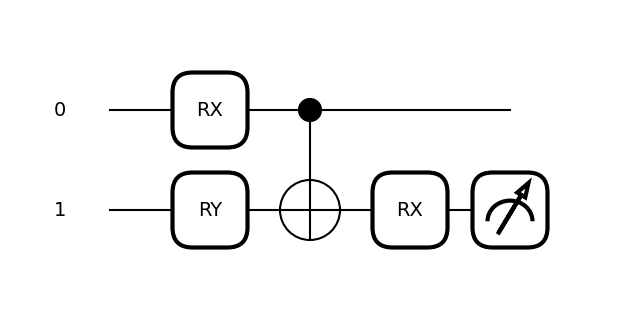

In [23]:
qml.draw_mpl(circuit)([0.1, 0.2, 0.3])

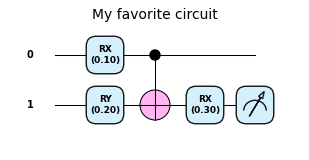

In [24]:
### Draw this circuit beautifully as in Qiskit
#   Lots of styles apply, e.g. 'black_white', 'black_white_dark', 'sketch', 
#     'pennylane', 'pennylane_sketch', 'sketch_dark', 'solarized_light', 'solarized_dark', 
#     'default', we can even use 'rcParams' to redefine all attributes
def draw_circuit(circuit, fontsize=20, style='pennylane', expansion_strategy=None, scale=None, title=None, decimals=2):
    def _draw_circuit(*args, **kwargs):
        nonlocal circuit, fontsize, style, expansion_strategy, scale, title
        qml.drawer.use_style(style)
        if expansion_strategy is None:
            expansion_strategy = circuit.expansion_strategy
        fig, ax = qml.draw_mpl(circuit, decimals=decimals, expansion_strategy=expansion_strategy)(*args, **kwargs)
        if scale is not None:
            dpi = fig.get_dpi()
            fig.set_dpi(dpi*scale)
        if title is not None:
            fig.suptitle(title, fontsize=fontsize)
        plt.show()
    return _draw_circuit

draw_circuit(circuit, scale=0.5, title='My favorite circuit', style='pennylane')([0.1, 0.2, 0.3])

## TorchLayer
*See: https://docs.pennylane.ai/en/stable/code/api/pennylane.qnn.TorchLayer.html*

### Mini-example

In [25]:
qubit_dev = "default.qubit"

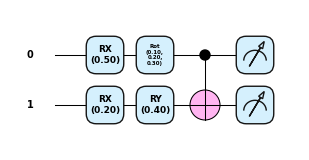

In [26]:
n_qubits = 2
dev = qml.device(qubit_dev, wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights_0, weight_1):
    qml.RX(inputs[0], wires=0)
    qml.RX(inputs[1], wires=1)
    qml.Rot(*weights_0, wires=0)
    qml.RY(weight_1, wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.Z(0)), qml.expval(qml.Z(1))

draw_circuit(qnode, scale=0.5)([0.5, 0.2], [0.1, 0.2, 0.3], 0.4)

In [27]:
weight_shapes = {"weights_0": 3, "weight_1": 1}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)
clayer = torch.nn.Linear(2, 2)
model = torch.nn.Sequential(qlayer, clayer)
model

Sequential(
  (0): <Quantum Torch Layer: func=qnode>
  (1): Linear(in_features=2, out_features=2, bias=True)
)

### Calculating output shape

In [28]:
def output_shape(measurements, show_circuit=False, n_qubits = 2, batch_dim = 5):
    
    dev = qml.device(qubit_dev, wires=n_qubits, shots=100)

    @qml.qnode(dev)
    def qnode(inputs, weights):
        qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
        qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
        if len(measurements) == 1:
            return qml.apply(measurements[0])
        else:
            return [qml.apply(m) for m in measurements]

    weight_shapes = {"weights": (3, n_qubits, 3)}
    qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)
    
    x = torch.zeros((batch_dim, n_qubits))
    if show_circuit:
        return qlayer
    else:
        return qlayer(x).shape

In [29]:
### Single measurements
print(output_shape([qml.expval(qml.Z(0))]))
print(output_shape([qml.probs(wires=[0, 1])]))
print(output_shape([qml.sample(wires=[0, 1])]))

torch.Size([5])
torch.Size([5, 4])
torch.Size([5, 100, 2])


In [30]:
### Multiple measurements
print(output_shape([qml.expval(qml.Z(0)), qml.probs(wires=[0, 1])]))
print(output_shape([qml.probs([0, 1]), qml.sample(wires=[0, 1])]))
print(output_shape([qml.expval(qml.Z(0)), qml.expval(qml.Z(1))]))

torch.Size([5, 5])
torch.Size([5, 204])
torch.Size([5, 2])


tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])


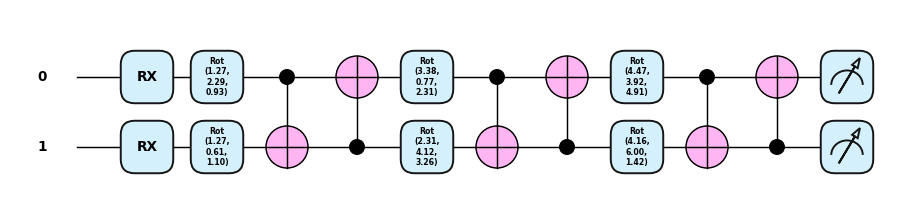

In [31]:
x = torch.zeros((5, 2))
print(x)
circ = output_shape([qml.expval(qml.Z(0)), qml.expval(qml.Z(1))], show_circuit=True, n_qubits=2)
draw_circuit(circ, scale=0.7, expansion_strategy='device')(x)

In [32]:
circ(x)

tensor([[-0.0800, -0.6800],
        [-0.0600, -0.7800],
        [-0.1000, -0.8400],
        [-0.0800, -0.7000],
        [ 0.1400, -0.6200]], grad_fn=<ViewBackward0>)

In [33]:
circ(x).shape

torch.Size([5, 2])

### TorchLayer with initialisation

In [34]:
init_method = torch.nn.init.normal_

In [35]:
@qml.qnode(dev)
def qnode(inputs, weights_0, weights_1, weights_2, weight_3, weight_4):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights_0, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights_1, wires=range(n_qubits))
    qml.Rot(*weights_2, wires=0)
    qml.RY(weight_3, wires=1)
    qml.RZ(weight_4, wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.Z(0)), qml.expval(qml.Z(1))


weight_shapes = {
    "weights_0": (3, n_qubits, 3),
    "weights_1": (3, n_qubits),
    "weights_2": 3,
    "weight_3": 1,
    "weight_4": (1,),
}

init_method = {
    "weights_0": torch.nn.init.normal_,
    "weights_1": torch.nn.init.uniform_,
    "weights_2": torch.tensor([1., 2., 3.]),
    "weight_3": torch.tensor(1.),  # scalar when shape is not an iterable and is <= 1
    "weight_4": torch.tensor([1.]),
}

qlayer = qml.qnn.TorchLayer(qnode, weight_shapes=weight_shapes, init_method=init_method)

In [36]:
### Save, when Torch model includes TorchLayer you can only save its state 
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes=weight_shapes)
clayer = torch.nn.Linear(2, 2)
model = torch.nn.Sequential(qlayer, clayer)
torch.save(model.state_dict(), '../xx_test_torch_layer.qnn')

In [37]:
### Load the TorchLayer back
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes=weight_shapes)
clayer = torch.nn.Linear(2, 2)
model = torch.nn.Sequential(qlayer, clayer)
model.load_state_dict(torch.load('../xx_test_torch_layer.qnn'))
model.eval()

Sequential(
  (0): <Quantum Torch Layer: func=qnode>
  (1): Linear(in_features=2, out_features=2, bias=True)
)

### Full TorchLayer example

*The code block below shows how a circuit composed of templates from the Templates module can be combined with classical Linear layers to learn the two-dimensional moons dataset.*

In [45]:
qubit_dev = 'lightning.qubit'

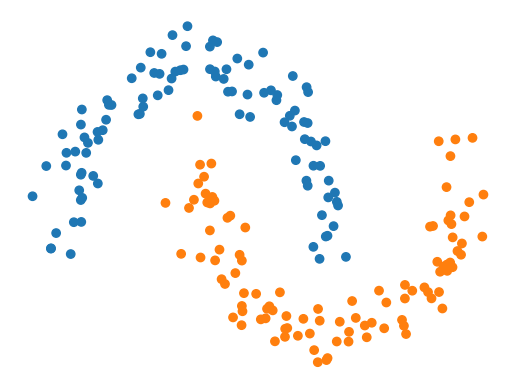

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

X, y = make_moons(n_samples=200, noise=0.1)
y_ = torch.unsqueeze(torch.tensor(y), 1)  # used for one-hot encoded labels
y_hot = torch.scatter(torch.zeros((200, 2)), 1, y_, 1)

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

In [47]:
X = torch.tensor(X, requires_grad=True).float()
y_hot = y_hot.float()

#### BasicEntanglerLayers

In [48]:
### Create a simple circuit

import pennylane as qml

n_qubits = 2
dev = qml.device(qubit_dev, wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [49]:
### Now create a Torch model with TorchLayer

n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}

qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)
clayer_1 = torch.nn.Linear(2, 2)
clayer_2 = torch.nn.Linear(2, 2)
softmax = torch.nn.Softmax(dim=1)
layers = [clayer_1, qlayer, clayer_2, softmax]
model = torch.nn.Sequential(*layers)
model

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): <Quantum Torch Layer: func=qnode>
  (2): Linear(in_features=2, out_features=2, bias=True)
  (3): Softmax(dim=1)
)

In [50]:
### Select optimizer and loss function

opt = torch.optim.SGD(model.parameters(), lr=0.2)
loss = torch.nn.L1Loss()

In [51]:
### Train the model

batch_size = 5
batches = 200 // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(X, y_hot)), batch_size=5, shuffle=True, drop_last=True
)

epochs = 10

for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

y_pred = model(X)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

Average loss over epoch 1: 0.4941
Average loss over epoch 2: 0.4214
Average loss over epoch 3: 0.2848
Average loss over epoch 4: 0.2122
Average loss over epoch 5: 0.1851
Average loss over epoch 6: 0.1661
Average loss over epoch 7: 0.1638
Average loss over epoch 8: 0.1626
Average loss over epoch 9: 0.1586
Average loss over epoch 10: 0.1585
Accuracy: 86.0%


#### The same with StronglyEntanglingLayers

In [52]:
### Prepare the model

n_qubits = 2
dev = qml.device(qubit_dev, wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]
    #return qml.expval(qml.Z(0)), qml.expval(qml.Z(1))

n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits, 3)}

qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)
clayer1 = torch.nn.Linear(2, 2)
clayer2 = torch.nn.Linear(2, 2)
softmax = torch.nn.Softmax(dim=1)
model = torch.nn.Sequential(clayer1, qlayer, clayer2, softmax)

opt = torch.optim.SGD(model.parameters(), lr=0.5)
loss = torch.nn.L1Loss()

In [53]:
### Train the model

epochs = 20
batch_size = 5
batches = 200 // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(X, y_hot)), batch_size=5, shuffle=True, drop_last=True
)

for epoch in range(epochs):

    running_loss = 0

    for xb, yb in data_loader:
        opt.zero_grad()

        loss_evaluated = loss(model(xb), yb)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

y_pred = model(X)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

Average loss over epoch 1: 0.3654
Average loss over epoch 2: 0.1985
Average loss over epoch 3: 0.1743
Average loss over epoch 4: 0.1676
Average loss over epoch 5: 0.1559
Average loss over epoch 6: 0.1464
Average loss over epoch 7: 0.1546
Average loss over epoch 8: 0.1545
Average loss over epoch 9: 0.1528
Average loss over epoch 10: 0.1618
Average loss over epoch 11: 0.1565
Average loss over epoch 12: 0.1616
Average loss over epoch 13: 0.1588
Average loss over epoch 14: 0.1358
Average loss over epoch 15: 0.1655
Average loss over epoch 16: 0.1360
Average loss over epoch 17: 0.1349
Average loss over epoch 18: 0.1381
Average loss over epoch 19: 0.1534
Average loss over epoch 20: 0.1414
Accuracy: 86.5%


## Software used
*JAX will complain about os.fork used in executing the command*

In [54]:
!pip list | grep -e PennyLane -e torch -e jax -e networkx

/home/jacob/miniconda3/envs/pl/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


jax                           0.4.31
jaxlib                        0.4.31
networkx                      2.8.8
PennyLane                     0.36.0
PennyLane_Lightning           0.36.0
PennyLane-qiskit              0.36.0
PennyLane-Rigetti             0.36.0
torch                         2.3.1
torchaudio                    2.3.1
torchsummary                  1.5.1
torchvision                   0.18.1
